### Cегментирование изображений домашних животных из датасета Oxford-IIIT Pet Dataset с использованием модифицированной версии U-Net.

In [1]:
# Copyright 2019 The TensorFlow Authors.
# Licensed under the Apache License, Version 2.0 (the "License");

In [2]:
#!pip install git+https://github.com/tensorflow/examples.git

In [3]:
#!pip install -U tfds-nightly

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

import tensorflow as tf

In [5]:
print(tf.__version__)

2.1.0


In [6]:
print(tfds.__version__)

3.2.1


In [7]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
dataset, info = tfds.load('oxford_iiit_pet:3.2.0', with_info=True)

In [9]:
dataset['train']

<PrefetchDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>

In [10]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [11]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [12]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [13]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 32
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [14]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [15]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [16]:
def display(display_list):
    plt.figure(figsize=(12, 12))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

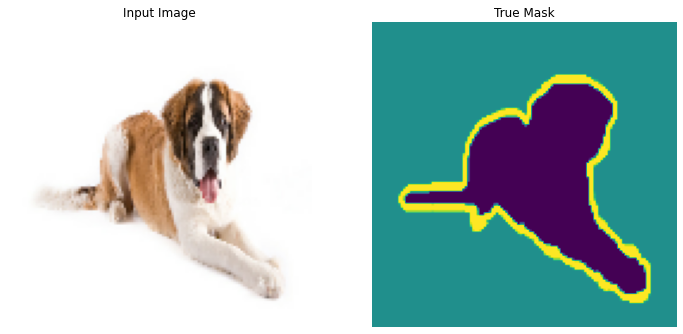

In [17]:
for image, mask in train.take(12):
    sample_image, sample_mask = image, mask

display([sample_image, sample_mask])

In [18]:
OUTPUT_CHANNELS = 3

In [19]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(output_channels, 3, strides=2, padding='same')  #64x64 -> 128x128
    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [20]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [21]:
def show_predictions(dataset=None, num=12):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [22]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

### В качестве энкодера возьмём InceptionV3

In [23]:
base_model = tf.keras.applications.DenseNet201(input_shape=[128, 128, 3], include_top=False)
#base_model.summary()

In [24]:
from IPython.display import Image
Image(url= "U-net.png")

In [25]:
layer_names = [
    'conv1/relu',            # 64x64  64 0
    'conv2_block5_1_relu',   # 32x32 128 0
    'conv3_block5_0_relu',   # 16x16 256 0
    'conv4_block9_0_relu',   # 8x8   512 0
    'conv5_block30_1_conv'   # 4x4   128 233472
]

layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [26]:
layers

[<tf.Tensor 'conv1/relu/Identity:0' shape=(None, 64, 64, 64) dtype=float32>,
 <tf.Tensor 'conv2_block5_1_relu/Identity:0' shape=(None, 32, 32, 128) dtype=float32>,
 <tf.Tensor 'conv3_block5_0_relu/Identity:0' shape=(None, 16, 16, 256) dtype=float32>,
 <tf.Tensor 'conv4_block9_0_relu/Identity:0' shape=(None, 8, 8, 512) dtype=float32>,
 <tf.Tensor 'conv5_block30_1_conv/Identity:0' shape=(None, 4, 4, 128) dtype=float32>]

In [27]:
up_stack = [
    pix2pix.upsample(512, 3),
    pix2pix.upsample(256, 3),
    pix2pix.upsample(128, 3),
    pix2pix.upsample(64, 3)
]

In [43]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

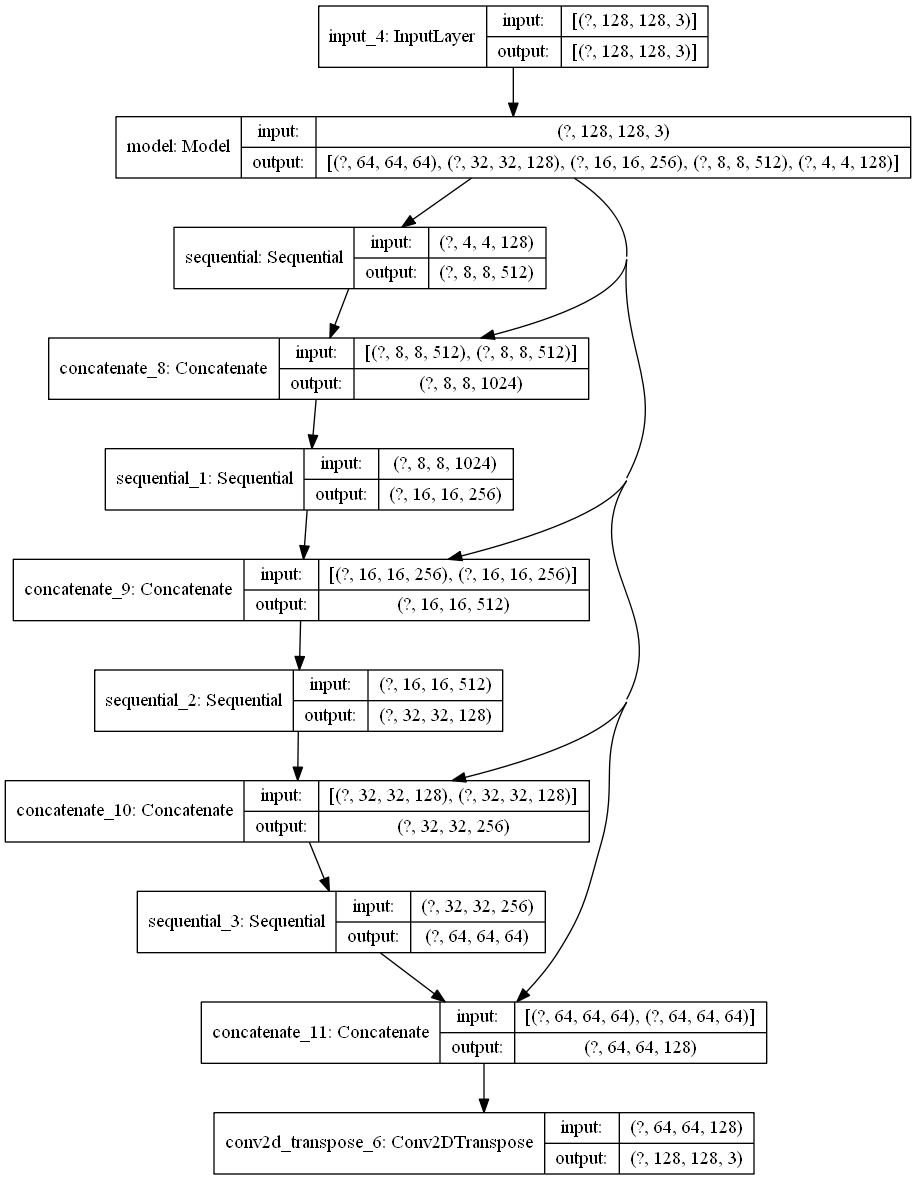

In [44]:
tf.keras.utils.plot_model(model, show_shapes=True)

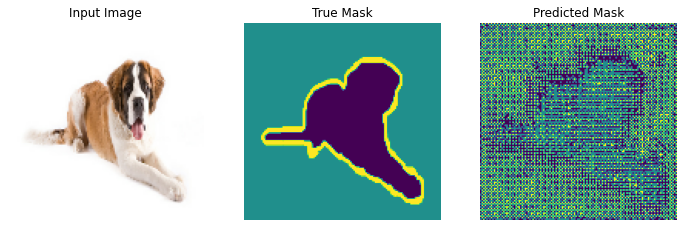

In [45]:
show_predictions()

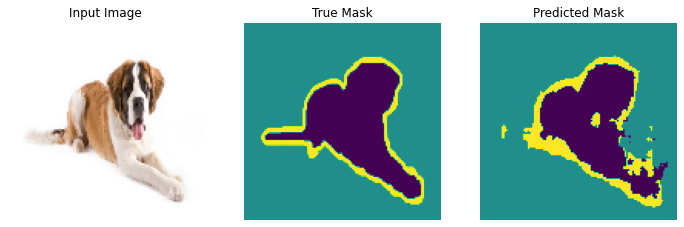


Sample Prediction after epoch 5

115/115 [==============================] - 9s 82ms/step - loss: 0.1374 - accuracy: 0.9371 - val_loss: 0.4009 - val_accuracy: 0.8694


In [46]:
EPOCHS = 5
BATCH_SIZE = 32
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

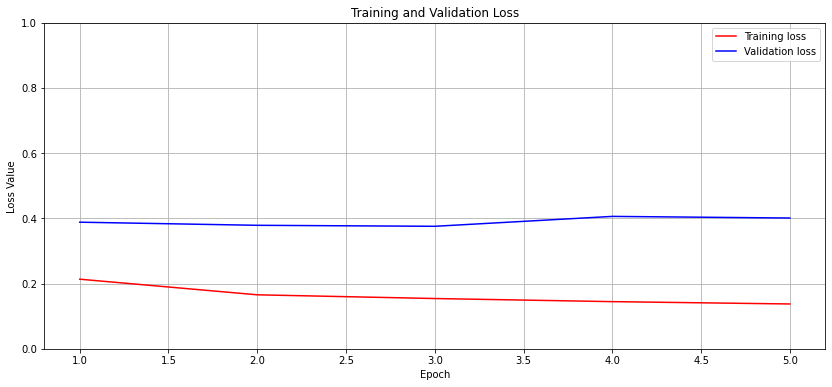

In [47]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1,EPOCHS+1)
plt.figure(figsize=(14, 6))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.grid()
plt.show()

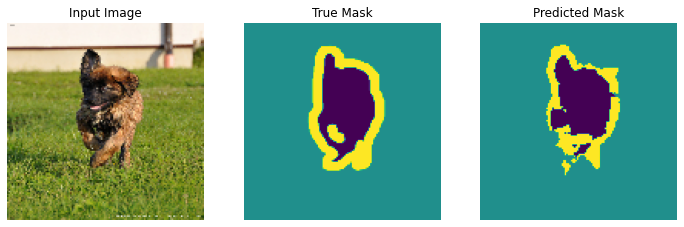

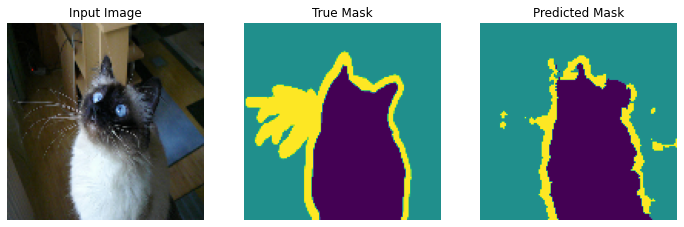

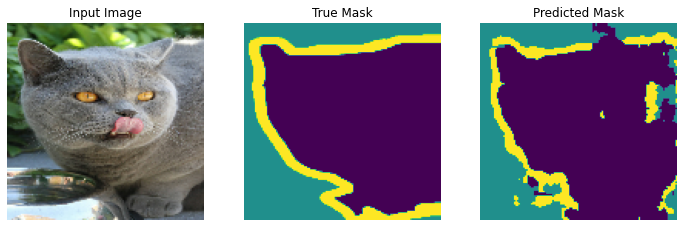

In [48]:
show_predictions(test_dataset, 3)

### Попробуем создать свою U-net модель

In [49]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Reshape, Activation, UpSampling2D
from tensorflow.keras import Input, Model
from tensorflow.keras.backend import concatenate
from tensorflow.keras import callbacks

In [98]:
def get_unet(dim=128, dropout=0.5, n_classes=3):
    inputs = Input((dim, dim, 3))
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    conv4 = Dropout(dropout)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    conv5 = Dropout(dropout)(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    conv10 = Conv2D(n_classes, 1, 1, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    #conv10 = Reshape((dim * dim, n_classes))(conv10)

    output = Activation('softmax')(conv10)

    model = Model(inputs=[inputs], outputs=[output])

    return model

In [102]:
# tf.keras.optimizers.Adam(learning_rate=0.0075)
# tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
unet_model = get_unet()
unet_model.compile(optimizer='adadelta',
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'], sample_weight_mode='temporal')

In [103]:
unet_model.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_228 (Conv2D)             (None, 128, 128, 64) 1792        input_17[0][0]                   
__________________________________________________________________________________________________
conv2d_229 (Conv2D)             (None, 128, 128, 64) 36928       conv2d_228[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_48 (MaxPooling2D) (None, 64, 64, 64)   0           conv2d_229[0][0]                 
___________________________________________________________________________________________

In [104]:
#reduce_lr_cback = callbacks.ReduceLROnPlateau(
#    monitor='val_loss', factor=0.5, patience=2)

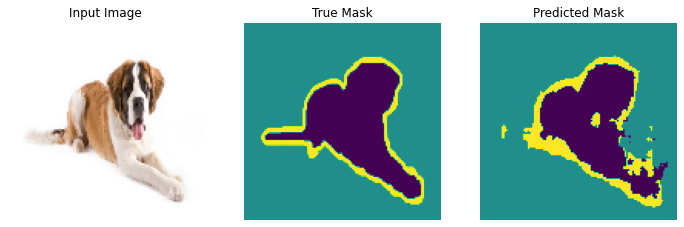


Sample Prediction after epoch 3

115/115 [==============================] - 37s 322ms/step - loss: 0.9161 - accuracy: 0.6560 - val_loss: 0.9425 - val_accuracy: 0.6637


In [105]:
EPOCHS = 3
model_history = unet_model.fit(train_dataset,
                epochs=EPOCHS,
                steps_per_epoch=STEPS_PER_EPOCH,
                validation_steps=VALIDATION_STEPS,
                validation_data=test_dataset,
                callbacks=[DisplayCallback()])

In [106]:
model_history.history

{'loss': [0.9907130972198818, 0.9398459688476895, 0.9161241339600604],
 'accuracy': [0.5806755, 0.62043375, 0.6560242],
 'val_loss': [0.9875445122068579, 0.9556243473833258, 0.9424947689880024],
 'val_accuracy': [0.5964161, 0.6636679, 0.6636852]}

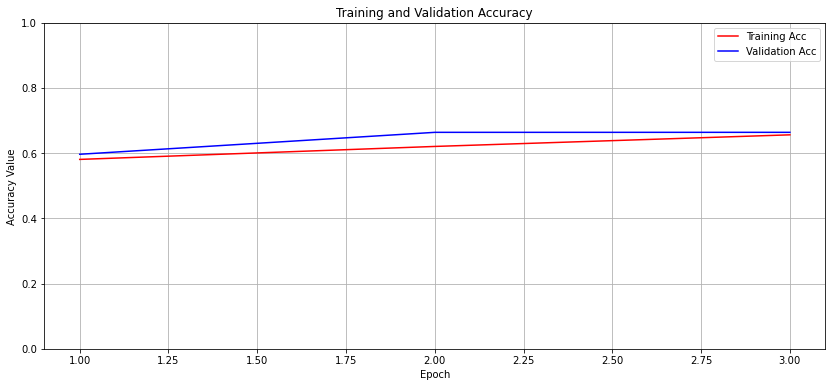

In [108]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
epochs = range(1,EPOCHS+1)
plt.figure(figsize=(14, 6))
plt.plot(epochs, acc, 'r', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.ylim([0, 1])
plt.legend()
plt.grid()
plt.show()